In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/ColabNotebooks/AN2DL/Homework1/

/gdrive/MyDrive/ColabNotebooks/AN2DL/Homework1


In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Labels of the dataset for classification
labels = {0:"Species1",              # 0
          1:"Species2",              # 1
          2:"Species3",              # 2
          3:"Species4",              # 3
          4:"Species5",              # 4
          5:"Species6",              # 5
          6:"Species7",              # 6
          7:"Species8"}              # 7

In [6]:
model_d=EfficientNetV2L(weights='imagenet',include_top=False, input_shape=(96, 96, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(8,activation='softmax')(x) #FC-layer

model=Model(inputs=model_d.input,outputs=preds)
model.summary()

473176280/473176280 [==============================] - 22s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                          

In [7]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                              

In [9]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("training_data_final/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("training_data_final/"+img)))
    for i in path:
        image = cv2.imread("training_data_final/"+img+'/'+i)
        image = cv2.resize(image, (96,96))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Species4', 'Species5', 'Species7', 'Species8', 'Species3', 'Species6', 'Species1', 'Species2']


In [14]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

data = tfa.image.random_cutout(data, (96, 96), constant_values = 1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0 0 0]


In [11]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(2833, 96, 96, 3) (709, 96, 96, 3)


In [12]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.06936, saving model to model.h5
22/22 - 66s - loss: 2.8965 - accuracy: 0.1346 - val_loss: 2.0694 - val_accuracy: 0.1790 - lr: 0.0010 - 66s/epoch - 3s/step
Epoch 2/50

Epoch 2: val_loss improved from 2.06936 to 2.06436, saving model to model.h5
22/22 - 27s - loss: 2.5867 - accuracy: 0.1287 - val_loss: 2.0644 - val_accuracy: 0.1493 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss improved from 2.06436 to 2.02568, saving model to model.h5
22/22 - 27s - loss: 2.4291 - accuracy: 0.1575 - val_loss: 2.0257 - val_accuracy: 0.1655 - lr: 0.0010 - 27s/epoch - 1s/step
Epoch 4/50

Epoch 4: val_loss did not improve from 2.02568
22/22 - 19s - loss: 2.3663 - accuracy: 0.1590 - val_loss: 2.0273 - val_accuracy: 0.1507 - lr: 0.0010 - 19s/epoch - 854ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 2.02568
22/22 - 29s - loss: 2.3816 - accuracy: 0.1564 - val_loss: 2.0295 - val_accuracy: 0.1543 - lr: 0.0010 - 29s/epoch - 1s/step
E

In [13]:
# Saving the last epoch of the train
save_dir = os.path.join('EfficientNet')
model.save(save_dir)

In [14]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

23/23 [==============================] - 10s 140ms/step
Total-test-data; 709 	accurately-predicted-data: 133 	 wrongly-predicted-data:  576
Accuracy: 18.759 %


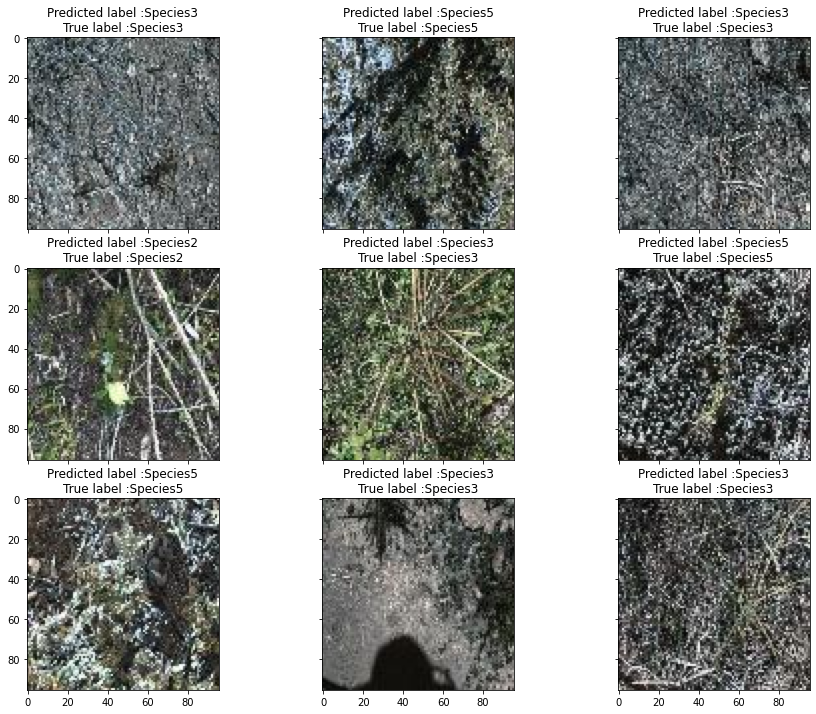

In [15]:
label=['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()